# Importing Module and define directories

In [14]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
importlib.reload(MLP)
from MLP import MLP

# Train - Validation Split

In [15]:
data=np.loadtxt("../../data/TR.csv",delimiter=",")
input_data=data[:,1:-2][0:1000]
labels=data[:,-2:][0:1000]
val_data=data[:,1:-2][1000:-1]
val_labels=data[:,-2:][1000:-1]

# Define the MLP

In [16]:
structure=[10,8,20,np.shape(labels)[1]]
act_func=[("sigmoid",1),("sigmoid",1),("sigmoid",1),("linear",1)]
start=[0.001,0.05,0.05,0.01]

netw = MLP(structure, func=act_func,
           starting_points=start)

## Train the model

In [19]:
N_epoch = 50
learning_rate=5e-5
lamb=0
batch_size = 1 #-1 for batch gradient descent
netw.train(input_data, labels, val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = learning_rate, lamb = lamb)

Epoch 100:  [train MEE = 2.8987]  [val MEE = 2.8238]                              
Elapsed time: 9.87368369102478 s


# Plot results

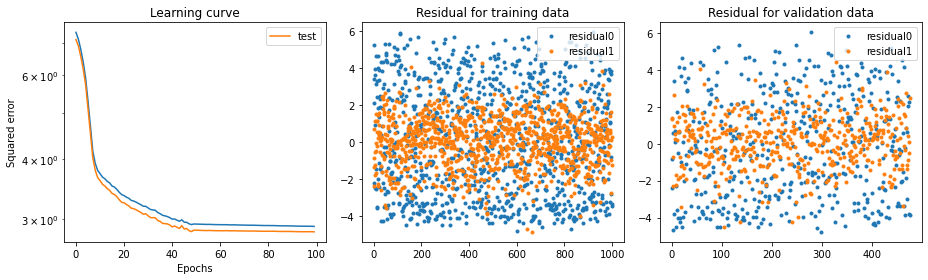

In [20]:
def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_results(netw)

In [21]:
netw.predict(input_data)

array([[  3.75974086,  -9.50653804],
       [  2.37840805, -24.54832783],
       [  2.06966166, -28.19283477],
       ...,
       [  1.97584095, -29.34883157],
       [  2.3876931 , -24.44193247],
       [  3.00173229, -17.62851963]])